In [ ]:
# 1) download the dataset zip file from https://www.kaggle.com/datasets/mamun1113/doctors-handwritten-prescription-bd-dataset/data
# in /content/sample_data dir
# 2) !unzip archive1.zip

!unzip '/content/sample_data/archive1.zip'
!pip install pandas numpy scikit-learn tensorflow keras opencv-python

Archive:  /content/sample_data/archive1.zip
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/0.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/1.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/10.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/100.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/101.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/102.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/103.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/104.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testing/testing_words/105.png  
  inflating: Doctor’s Handwritten Prescription BD dataset/Testin

In [ ]:
import tensorflow as tf
import os
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Load labels
data_folder = "/content/Doctor’s Handwritten Prescription BD dataset"
label_file = data_folder + "/Training/training_labels.csv"

labels_df = pd.read_csv(label_file)

# Print column names to verify
print("labels_df.columns=",labels_df.columns)

Num GPUs Available:  0
labels_df.columns= Index(['IMAGE', 'MEDICINE_NAME', 'GENERIC_NAME'], dtype='object')


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Constants
IMG_SIZE = (64, 64)
NUM_CLASSES = 78
BATCH_SIZE = 32
EPOCHS = 20 #TODO change to 20
LEARNING_RATE = 0.001
MODEL_FILENAME = 'prescription_classification_model.keras'

def load_data(image_folder, label_file, filename_col='IMAGE', label_col='MEDICINE_NAME', target_img_size = IMG_SIZE):
    """
    Load images and labels from the specified folder and CSV file.
    """

    # Load labels
    labels_df = pd.read_csv(label_file)
    print(f"First few rows of the dataframe from {label_file}:")
    print(labels_df.head())

    # Load images and labels
    images, labels = [], []
    for _, row in labels_df.iterrows():
        img_path = os.path.join(image_folder, row[filename_col])
        img = load_img(img_path, target_size=target_img_size)
        img = img_to_array(img)
        images.append(img)
        labels.append(row[label_col])

    # Convert lists to numpy arrays
    images = np.array(images, dtype="float32") / 255.0  # Normalize
    labels = np.array(labels)
    return images, labels

def load_and_preprocess_data(data_folder):
    """
    Load and preprocess training, validation, and testing datasets.
    Returns X_train, y_train, X_valid, y_valid, X_test, y_test.
    """
    # Load and preprocess training data
    train_image_folder = os.path.join(data_folder, 'Training/training_words')
    train_label_file   = os.path.join(data_folder, 'Training/training_labels.csv')
    X_train, y_train_labels = load_data(train_image_folder, train_label_file)
    y_train, label_encoder = preprocess_labels(y_train_labels)

    # Load and preprocess validation data
    valid_image_folder = os.path.join(data_folder, 'Validation/validation_words')
    valid_label_file   = os.path.join(data_folder, 'Validation/validation_labels.csv')
    X_valid, y_valid_labels = load_data(valid_image_folder, valid_label_file)
    y_valid, _ = preprocess_labels(y_valid_labels)

    # Load and preprocess testing data
    test_image_folder = os.path.join(data_folder, 'Testing/testing_words')
    test_label_file   = os.path.join(data_folder, 'Testing/testing_labels.csv')
    X_test, y_test_labels = load_data(test_image_folder, test_label_file)
    y_test, _ = preprocess_labels(y_test_labels)

    return X_train, y_train, X_valid, y_valid, X_test, y_test


def preprocess_labels(labels):
    """
    Encode labels as integers and convert to categorical format.
    """
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_categorical = to_categorical(labels_encoded, num_classes=NUM_CLASSES)
    return labels_categorical, label_encoder

def build_model(input_shape=(64, 64, 3), num_classes=NUM_CLASSES):
    """
    Build a CNN model for image classification.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ]) # This had accuracy rate of

    # model = Sequential()
    # model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(64, (3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(128, (3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Conv2D(256, (3, 3), activation='relu'))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    # model.add(Flatten())
    # model.add(Dense(512, activation='relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(78, activation='softmax'))


    return model

def compile_model(model, learning_rate=LEARNING_RATE):
    """
    Compile the model with specified optimizer, loss, and metrics.
    """
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_model(model, X_train, y_train, X_test, y_test, batch_size=BATCH_SIZE, epochs=EPOCHS):
    """
    Train the model with training data and validate on test data.
    """
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size
    )
    return history

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on the test set.
    """
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    return loss, accuracy

def save_model(model, filename=MODEL_FILENAME):
    """
    Save the trained model to disk.
    """
    model.save(filename)


# Main workflow
def main(data_folder):

    # Load and preprocess data
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_and_preprocess_data(data_folder)

    # Build, compile and train model
    model = build_model(input_shape=IMG_SIZE + (3,))
    model = compile_model(model)
    history = train_model(model, X_train, y_train, X_valid, y_valid)

    save_model(model) #save it so I can train it again.

    #Evaluate and save the model
    evaluate_model(model, X_test, y_test)
    # save_model(model)


# If this script is run directly, execute the main function
if __name__ == "__main__":
    data_folder = "/content/Doctor’s Handwritten Prescription BD dataset"
    main(data_folder)


# New Section

First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Training/training_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol
First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol
First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta 

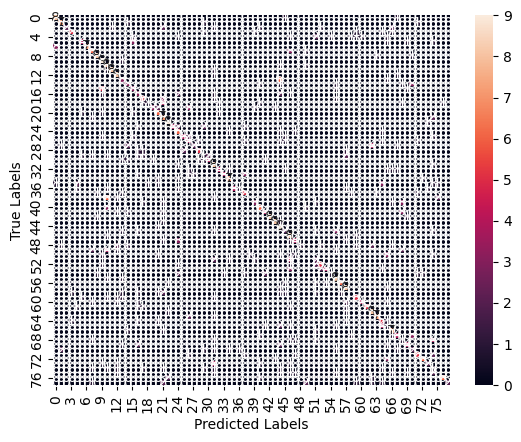

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

X_train, y_train, X_valid, y_valid, X_test, y_test = load_and_preprocess_data(data_folder)

# Generate predictions and create confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true_classes, y_pred_classes))

top_k_accuracy = tf.keras.metrics.top_k_categorical_accuracy(y_test_labels, y_pred, k=5)
print("Top-5 Accuracy:", np.mean(top_k_accuracy))


              precision    recall  f1-score   support

           0       0.67      0.80      0.73        10
           1       0.64      0.70      0.67        10
           2       1.00      0.20      0.33        10
           3       0.71      0.50      0.59        10
           4       0.00      0.00      0.00        10
           5       0.57      0.40      0.47        10
           6       1.00      0.70      0.82        10
           7       0.43      0.60      0.50        10
           8       0.73      0.80      0.76        10
           9       0.45      0.90      0.60        10
          10       0.29      0.80      0.42        10
          11       0.89      0.80      0.84        10
          12       0.44      0.80      0.57        10
          13       0.27      0.30      0.29        10
          14       0.30      0.30      0.30        10
          15       0.33      0.30      0.32        10
          16       0.21      0.30      0.25        10
          17       0.45    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#Now we re-train the model using data augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

# Load the trained model that was saved earlier
MODEL_FILENAME = 'prescription_classification_model.keras'
model = load_model(MODEL_FILENAME)

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

X_train, y_train, X_valid, y_valid, X_test, y_test = load_and_preprocess_data(data_folder)

# Fit the generator to the training data
datagen.fit(X_train)

# Train the model with augmented data
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_valid, y_valid), epochs=20)

#Evalute the mmodel on test data
evaluate_model(model, X_test, y_test)

MODEL_FILENAME_AFTER_DATA_AUG = 'prescription_classification_model_after_data_aug.keras'
save_model(model, MODEL_FILENAME_AFTER_DATA_AUG)


First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Training/training_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol
First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol
First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 33s 324ms/step - accuracy: 0.1452 - loss: 4.3079 - val_accuracy: 0.5667 - val_loss: 1.7767
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 268ms/step - accuracy: 0.2496 - loss: 3.1185 - val_accuracy: 0.6718 - val_loss: 1.3505
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 276ms/step - accuracy: 0.2935 - loss: 2.8535 - val_accuracy: 0.6615 - val_loss: 1.3712
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 27s 266ms/step - accuracy: 0.3772 - loss: 2.4937 - val_accuracy: 0.6846 - val_loss: 1.3297
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 270ms/step - accuracy: 0.3895 - loss: 2.3719 - val_accuracy: 0.7103 - val_loss: 1.1914
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 26s 263ms/step - accuracy: 0.4444 - loss: 2.1718 - val_accuracy: 0.6346 - val_loss: 1.4751
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 42s 277ms/step - accuracy: 0.4709 - loss: 2.0896 - val_accuracy: 0.6962 - val_loss: 1.2163
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 274ms/step - accuracy: 0.4914 - loss: 1.9245 - val_accuracy: 0.685

In [ ]:
# Now I increase the model depth. (NOTE: It made the model worse. The accuracy went down )

# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(78, activation='softmax'))

# model = compile_model(model)
# history = train_model(model, X_train, y_train, X_valid, y_valid)

# MODEL_FILENAME_AFTER_DEPTH_INCREASE = 'prescription_classification_model_after_depth_increase.keras'
# save_model(model,MODEL_FILENAME_AFTER_DEPTH_INCREASE)

# #Evaluate and save the model
# evaluate_model(model, X_test, y_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 29s 270ms/step - accuracy: 0.0094 - loss: 4.3723 - val_accuracy: 0.0128 - val_loss: 4.3567
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 40s 259ms/step - accuracy: 0.0083 - loss: 4.3575 - val_accuracy: 0.0128 - val_loss: 4.3567
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 40s 249ms/step - accuracy: 0.0160 - loss: 4.3570 - val_accuracy: 0.0128 - val_loss: 4.3567
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 44s 276ms/step - accuracy: 0.0132 - loss: 4.3569 - val_accuracy: 0.0128 - val_loss: 4.3567
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 256ms/step - accuracy: 0.0086 - loss: 4.3571 - val_accuracy: 0.0128 - val_loss: 4.3567
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 25s 252ms/step - accuracy: 0.0115 - loss: 4.3571 - val_accuracy: 0.0128 - val_loss: 4.3567
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 253ms/step - accuracy: 0.0076 - loss: 4.3572 - val_accuracy: 0.0128 - val_loss: 4.3567
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - accuracy: 0.0085 - loss: 4.3572 - val_accu

(4.356712818145752, 0.012820512987673283)

In [ ]:
#Now I perform batch normalization to increase the accuracy of the model:
# - I am using augmented data
# - You  should build the model from scratch and not use the saved model, because the save model
#  did not contain BatchNormalization layers in the original model.
# BatchNormalization layers have their own trainable parameters (gamma, beta, moving_mean, moving_variance)
# which are expected to be loaded when you call load_weights. Since these layers didn't exist in the
# original model, the weights file doesn't contain these parameters, leading to the error.

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf  # If tf is not already imported


def build_model_with_batch_norm(input_shape=(64, 64, 3), num_classes=78):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),

        Dense(num_classes, activation='softmax')
    ])
    return model

# Create the new model with BatchNormalization
model_with_batch_norm = build_model_with_batch_norm()


# Compile the model
model_with_batch_norm.compile(optimizer=Adam(learning_rate=0.001),
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Train the new model from scratch
history = model_with_batch_norm.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_valid, y_valid),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

# Evaluate on the test set
evaluate_model(model_with_batch_norm, X_test, y_test)

MODEL_FILENAME_AFTER_BATCH_NORMALIZATION = 'prescription_classification_model_after_batch_normalization.keras'
save_model(model_with_batch_norm, MODEL_FILENAME_AFTER_BATCH_NORMALIZATION)  # Save the new model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 43s 392ms/step - accuracy: 0.0305 - loss: 4.7341 - val_accuracy: 0.0192 - val_loss: 6.3374
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 38s 386ms/step - accuracy: 0.0790 - loss: 4.1305 - val_accuracy: 0.0141 - val_loss: 6.1474
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 40s 376ms/step - accuracy: 0.1206 - loss: 3.7901 - val_accuracy: 0.0590 - val_loss: 5.1488
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 491ms/step - accuracy: 0.1646 - loss: 3.5359 - val_accuracy: 0.0526 - val_loss: 4.5704
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 44s 439ms/step - accuracy: 0.1981 - loss: 3.2846 - val_accuracy: 0.0551 - val_loss: 5.3240
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 45s 459ms/step - accuracy: 0.2260 - loss: 3.1004 - val_accuracy: 0.1397 - val_loss: 3.5542
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 73s 364ms/step - accuracy: 0.2801 - loss: 2.8464 - val_accuracy: 0.0769 - val_loss: 5.1279
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 41s 365ms/step - accuracy: 0.3185 - loss: 2.7400 - val_accuracy: 0.142

In [ ]:
#Now I increase the image size to (128,128) and also use data aug.

# Load and preprocess data


import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Constants
IMG_SIZE = (128, 128) # changed
NUM_CLASSES = 78
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

def load_data(image_folder, label_file, filename_col='IMAGE', label_col='MEDICINE_NAME', target_img_size = IMG_SIZE):
    """
    Load images and labels from the specified folder and CSV file.
    """

    # Load labels
    labels_df = pd.read_csv(label_file)
    print(f"First few rows of the dataframe from {label_file}:")
    print(labels_df.head())

    # Load images and labels
    images, labels = [], []
    for _, row in labels_df.iterrows():
        img_path = os.path.join(image_folder, row[filename_col])
        img = load_img(img_path, target_size=target_img_size)
        img = img_to_array(img)
        images.append(img)
        labels.append(row[label_col])

    # Convert lists to numpy arrays
    images = np.array(images, dtype="float32") / 255.0  # Normalize
    labels = np.array(labels)
    return images, labels

def load_and_preprocess_data(data_folder):
    """
    Load and preprocess training, validation, and testing datasets.
    Returns X_train, y_train, X_valid, y_valid, X_test, y_test.
    """
    # Load and preprocess training data
    train_image_folder = os.path.join(data_folder, 'Training/training_words')
    train_label_file   = os.path.join(data_folder, 'Training/training_labels.csv')
    X_train, y_train_labels = load_data(train_image_folder, train_label_file)
    y_train, label_encoder = preprocess_labels(y_train_labels)

    # Load and preprocess validation data
    valid_image_folder = os.path.join(data_folder, 'Validation/validation_words')
    valid_label_file   = os.path.join(data_folder, 'Validation/validation_labels.csv')
    X_valid, y_valid_labels = load_data(valid_image_folder, valid_label_file)
    y_valid, _ = preprocess_labels(y_valid_labels)

    # Load and preprocess testing data
    test_image_folder = os.path.join(data_folder, 'Testing/testing_words')
    test_label_file   = os.path.join(data_folder, 'Testing/testing_labels.csv')
    X_test, y_test_labels = load_data(test_image_folder, test_label_file)
    y_test, _ = preprocess_labels(y_test_labels)

    return X_train, y_train, X_valid, y_valid, X_test, y_test


def preprocess_labels(labels):
    """
    Encode labels as integers and convert to categorical format.
    """
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_categorical = to_categorical(labels_encoded, num_classes=NUM_CLASSES)
    return labels_categorical, label_encoder

def build_model(input_shape=IMG_SIZE + (3,), num_classes=NUM_CLASSES):
    """
    Build a CNN model for image classification.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

def compile_model(model, learning_rate=LEARNING_RATE):
    """
    Compile the model with specified optimizer, loss, and metrics.
    """
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_model(model, X_train, y_train, X_test, y_test, batch_size=BATCH_SIZE, epochs=EPOCHS):
    """
    Train the model with training data and validate on test data.
    """
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=epochs,
        batch_size=batch_size
    )
    return history

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on the test set.
    """
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    return loss, accuracy

def save_model(model, filename=MODEL_FILENAME):
    """
    Save the trained model to disk.
    """
    model.save(filename)


X_train, y_train, X_valid, y_valid, X_test, y_test = load_and_preprocess_data(data_folder)

model = build_model(input_shape=IMG_SIZE + (3,))
model = compile_model(model)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_valid, y_valid), epochs=20)

#Evaluate and save the model
evaluate_model(model, X_test, y_test)

MODEL_FILENAME_AFTER_INCREASE_IN_IMG_SIZE = 'prescription_classification_model_after_increase_in_img_size.keras'
save_model(model_with_batch_norm, MODEL_FILENAME_AFTER_INCREASE_IN_IMG_SIZE)  # Save the new model






First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Training/training_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol
First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta  Paracetamol
First few rows of the dataframe from /content/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv:
   IMAGE MEDICINE_NAME GENERIC_NAME
0  0.png         Aceta  Paracetamol
1  1.png         Aceta  Paracetamol
2  2.png         Aceta  Paracetamol
3  3.png         Aceta  Paracetamol
4  4.png         Aceta 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


98/98 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.0119 - loss: 4.4024 - val_accuracy: 0.0128 - val_loss: 4.2958
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.0145 - loss: 4.3018 - val_accuracy: 0.0410 - val_loss: 4.1714
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.0319 - loss: 4.1994 - val_accuracy: 0.0679 - val_loss: 4.1058
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.0530 - loss: 4.1348 - val_accuracy: 0.0872 - val_loss: 3.9678
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.0732 - loss: 4.0421 - val_accuracy: 0.1167 - val_loss: 3.9024
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.0792 - loss: 3.9721 - val_accuracy: 0.1244 - val_loss: 3.8029
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.1071 - loss: 3.8551 - val_accuracy: 0.1782 - val_loss: 3.5987
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.1162 - loss: 3.7074 - val_accuracy: 0.1705 - val_loss: 3.